In [1]:
# Nash Cascade Neural Network
# A hydrologically intuitive deep learning network

# Set up a solution to a network of buckets where the number of buckets in each layer
# flows out to the buckets in the next layer
# The parameter on each bucket is the size and height of each spigot.

# Need a function that solves this individually at a single buckets
# Then a function that loops through and moves the water to the downstream buckets

In [2]:
import torch
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from ncn_fcnn import NashCascadeNetwork as ncn
from ncn_fcnn import train_model as train_ncnn
import matplotlib.font_manager as font_manager
# Precipitation standard variable name used in the ncnn model interface
PRECIP_SVN = "atmosphere_water__liquid_equivalent_precipitation_rate"
PRECIP_SVN_SEQ = "atmosphere_water__liquid_equivalent_precipitation_rate_seq"
PRECIP_RECORD = "atmosphere_water__liquid_equivalent_precipitation_rate_record"
DO_PLOT = True


In [3]:
N_TIMESTEPS = 2800 # network_precip_tensor.shape[0]

In [4]:

csv_file = "/Users/jmframe/data/ncnn/forcing_carmel250_2016.csv"
df = pd.read_csv(csv_file)
precip_values = df['preci'].tolist()
network_precip_tensor = torch.tensor(precip_values, dtype=torch.float32, requires_grad=False)
train_precip_tensor = torch.multiply(1000, network_precip_tensor[:N_TIMESTEPS])
total_mass_precip_in = torch.sum(train_precip_tensor)
print("total_mass_precip_in [mm]", total_mass_precip_in)
print("torch.max(train_precip_tensor) [mm/hr]", torch.max(train_precip_tensor))

total_mass_precip_in [mm] tensor(433.3000)
torch.max(train_precip_tensor) [mm/hr] tensor(8.5149)


In [5]:
streamflow_csv = "/Users/jmframe/data/ncnn/streamflow_usgs_carmel250_2016.csv"
df_flow = pd.read_csv(streamflow_csv)

# Extract streamflow values and convert to tensor
real_outflow_list = df_flow['Flow'].tolist()
obs_streamflow_tensor = torch.tensor(real_outflow_list, dtype=torch.float32, requires_grad=False)

# Convert drainage area from square miles to square meters
drainage_area_sq_miles = 193
sq_mile_to_sq_m = 2.58998811e6  # 1 square mile in m²
drainage_area_m2 = drainage_area_sq_miles * sq_mile_to_sq_m

# Assume an hourly time step (3600 seconds)
time_step_seconds = 3600

# Conversion factor: depth (mm) = (Q (m³/s) * time (s) * 1000) / area (m²)
conversion_factor = (time_step_seconds * 1000) / drainage_area_m2

# Convert streamflow to mm per time step
obs_streamflow_tensor = obs_streamflow_tensor * conversion_factor

# Slice the streamflow tensor to the first N_TIMESTEPS
train_obs_streamflow_tensor = obs_streamflow_tensor[:N_TIMESTEPS]
total_mass_streamflow_out = torch.sum(train_obs_streamflow_tensor)
print("total_mass_streamflow_out [mm]", total_mass_streamflow_out)
print("torch.max(obs_streamflow_tensor) [mm/hr]", torch.max(obs_streamflow_tensor))

total_mass_streamflow_out [mm] tensor(106.1356)
torch.max(obs_streamflow_tensor) [mm/hr] tensor(0.3808)


In [6]:
# Example 1
bucket_nn = ncn(cfg_file="./config_1_fcnn.json")
bucket_nn.initialize()
print("Initialized")
inital_mass_in_network = torch.sum(torch.stack(bucket_nn.sum_H_per_layer)).item()
print(f"Initial Mass in network at start: {inital_mass_in_network:.1f}")
network_outflow_list_1a = []

for i in range(N_TIMESTEPS):
    # Set the current precipitation value
    bucket_nn.set_value(PRECIP_SVN, torch.tensor(network_precip_tensor[i], requires_grad=True))

    # Update the network (this should internally prepare and use the FCNN inputs)
    bucket_nn.update()
    network_outflow_list_1a.append(bucket_nn.network_outflow.item())
    bucket_nn.summarize_network()
    ###########################################################################
    ###########################################################################

###########################################################################
bucket_nn.report_out_mass_balance()

origional_bucket_theta = copy.deepcopy(bucket_nn.theta.detach())


Using device: cpu
--------------
-----------
-------------

INITIAL THETA VALUES
tensor([0.9487, 0.7238, 0.4507, 0.3582, 0.5325, 0.4272, 0.4715, 0.6186, 0.8377],
       requires_grad=True)
--------------
-----------
-------------

Initialized
Initial Mass in network at start: 7.0


/var/folders/08/fcnqv5n16bd3p26sxm806b080000gp/T/ipykernel_11922/23490707.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bucket_nn.set_value(PRECIP_SVN, torch.tensor(network_precip_tensor[i], requires_grad=True))


Initial Mass in network: 7.0
Final Mass in network: 2.9
Total Mass out of network 4.6
Total precipitation into network 0.4
Mass balance for network is -0.000


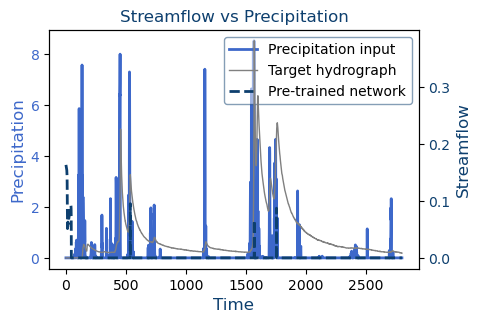

In [7]:
bigfontsize = 12
smallfontsize = 10
figure_width = 5  # inches
aspect_ratio = 3 / 2  # Adjust as needed for your plot
figure_height = figure_width / aspect_ratio

# Create figure and twin axes
fig, ax1 = plt.subplots(figsize=(figure_width, figure_height))
ax2 = ax1.twinx()

# Set colors
light_blue_color = "#3D68CA"
line_and_text_color = "#0D3F6E"

# Plot precipitation on the left y-axis (ax1)
ax1.plot(train_precip_tensor, c=light_blue_color, lw=2, label="Precipitation input")
ax1.set_ylabel("Precipitation", fontsize=bigfontsize, color=light_blue_color)
ax1.tick_params(axis='y', labelcolor=light_blue_color)

# Plot streamflow series on the right y-axis (ax2)
ax2.plot(train_obs_streamflow_tensor, c="grey", lw=1, label="Target hydrograph")
ax2.plot(network_outflow_list_1a, "--", lw=2, c=line_and_text_color, label="Pre-trained network")
ax2.set_ylabel("Streamflow", fontsize=bigfontsize, color=line_and_text_color)
ax2.tick_params(axis='y', labelcolor=line_and_text_color)

# Set common x-axis label
ax1.set_xlabel("Time", fontsize=bigfontsize, color=line_and_text_color)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=smallfontsize, edgecolor=line_and_text_color, framealpha=0.5)

plt.title("Streamflow vs Precipitation", fontsize=bigfontsize, color=line_and_text_color)

plt.tight_layout()
plt.show()
plt.close()

In [8]:
# print(thislinewillstopthenotebookfromrunningthecellsbelow)

In [9]:
network_precip_tensor.shape

torch.Size([8760])

In [10]:
obs_streamflow_tensor.shape

torch.Size([8760])

In [11]:
N_TRAIN_TIMESTEPS = N_TIMESTEPS
bucket_nn.set_value(PRECIP_RECORD, train_precip_tensor)
y_pred, loss = train_ncnn(bucket_nn, train_precip_tensor, train_obs_streamflow_tensor)
network_outflow_list_1b = list(y_pred.detach().numpy())
print(bucket_nn.theta)

INITIAL MODEL theta: tensor([0.5283, 0.4056, 0.4897, 0.4455, 0.4749, 0.5118, 0.5020, 0.5714, 0.4530],
       grad_fn=<SigmoidBackward0>)


/Users/jmframe/miniconda3/envs/bmi_lstm/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


0.0434:loss  ----- Training EPOCH 0 --- theta: tensor([0.5316, 0.3184, 0.6269, 0.3954, 0.5074, 0.5782, 0.5383, 0.5041, 0.5774],
       grad_fn=<SigmoidBackward0>)
Num non-zero gadients: 1, indices: 8, gradients: 8.299541150336154e-06
0.0425:loss  ----- Training EPOCH 1 --- theta: tensor([0.4419, 0.7010, 0.4048, 0.4064, 0.3859, 0.5102, 0.4289, 0.5619, 0.4985],
       grad_fn=<SigmoidBackward0>)
Num non-zero gadients: 1, indices: 8, gradients: 1.3731279977946542e-05
0.1730:loss  ----- Training EPOCH 2 --- theta: tensor([0.4527, 0.7567, 0.4409, 0.4989, 0.3680, 0.5300, 0.6786, 0.7040, 0.6274],
       grad_fn=<SigmoidBackward0>)
Num non-zero gadients: 0, indices: [], gradients: tensor([])
0.0578:loss  ----- Training EPOCH 3 --- theta: tensor([0.4012, 0.6245, 0.4981, 0.3240, 0.2852, 0.3369, 0.5108, 0.7353, 0.4701],
       grad_fn=<SigmoidBackward0>)
Num non-zero gadients: 0, indices: [], gradients: tensor([])
0.0234:loss  ----- Training EPOCH 4 --- theta: tensor([0.2870, 0.4538, 0.6163, 0.52

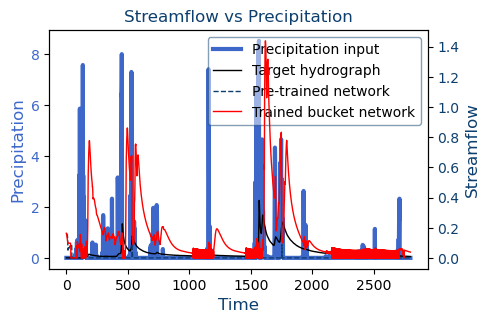

In [15]:

bigfontsize = 12
smallfontsize = 10
figure_width = 5  # inches
aspect_ratio = 3 / 2  # Adjust as needed for your plot
figure_height = figure_width / aspect_ratio

# Create figure and twin axes
fig, ax1 = plt.subplots(figsize=(figure_width, figure_height))
ax2 = ax1.twinx()

# Set colors
light_blue_color = "#3D68CA"
line_and_text_color = "#0D3F6E"

# Plot precipitation on the left y-axis (ax1)
ax1.plot(train_precip_tensor, c=light_blue_color, lw=3, label="Precipitation input")
ax1.set_ylabel("Precipitation", fontsize=bigfontsize, color=light_blue_color)
ax1.tick_params(axis='y', labelcolor=light_blue_color)

# Plot streamflow series on the right y-axis (ax2)
ax2.plot(train_obs_streamflow_tensor, c="k", lw=1, label="Target hydrograph")
ax2.plot(network_outflow_list_1a, "--", lw=1, c=line_and_text_color, label="Pre-trained network")
ax2.plot(network_outflow_list_1b, lw=1, c="r", label="Trained bucket network")
ax2.set_ylabel("Streamflow", fontsize=bigfontsize, color=line_and_text_color)
ax2.tick_params(axis='y', labelcolor=line_and_text_color)

# Set common x-axis label
ax1.set_xlabel("Time", fontsize=bigfontsize, color=line_and_text_color)

# Optionally, remove tick labels from x-axis if desired:
# ax1.set_xticks([])
# ax1.set_yticks([])

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=smallfontsize, edgecolor=line_and_text_color, framealpha=0.5)

plt.title("Streamflow vs Precipitation", fontsize=bigfontsize, color=line_and_text_color)

plt.tight_layout()
plt.show()
plt.close()

In [13]:
bucket_nn.network

{0: {'H': tensor([0.3779], grad_fn=<ViewBackward0>),
  'S': tensor([[[0.7576, 0.2793],
           [0.4031, 0.7347]]]),
  's_q': tensor([[0., 0.]], grad_fn=<SliceBackward0>)},
 1: {'H': tensor([0.0173, 0.3789], grad_fn=<ViewBackward0>),
  'S': tensor([[[0.0293, 0.7999]],
  
          [[0.3971, 0.7544]]]),
  's_q': tensor([[0.],
          [0.]], grad_fn=<SliceBackward0>)},
 2: {'H': tensor([0.5460], grad_fn=<ViewBackward0>),
  'S': tensor([[[0.5695, 0.4388],
           [0.6387, 0.5247]]]),
  's_q': tensor([[0., 0.]], grad_fn=<SliceBackward0>)},
 3: {'H': tensor([5.7104, 9.3804], grad_fn=<ViewBackward0>),
  'S': tensor([[[0.6826, 0.3051]],
  
          [[0.4635, 0.4550]]]),
  's_q': tensor([[0.0518],
          [0.0381]], grad_fn=<SliceBackward0>)},
 4: {'H': tensor([0.5847], grad_fn=<ViewBackward0>),
  'S': tensor([[[0.5725, 0.4980]]]),
  's_q': tensor([[0.0383]], grad_fn=<SliceBackward0>)}}

In [14]:
bucket_net.theta

NameError: name 'bucket_net' is not defined

In [ ]:
bucket_nn.theta

In [ ]:
origional_bucket_theta

In [ ]:
torch.sum(bucket_nn.theta - origional_bucket_theta)

In [ ]:
bucket_nn.theta - origional_bucket_theta